# BiteMe | Preprocessing

The purpose of this notebook is to create the image preprocessing pipeline to be used during train/test time. The output will be functions we can include in the `preprocessing.py` script. Parts of this notebook explore how best to optimise image preprocessing not only for performance, but for a testing environment. Functions therefore created enable iterative, logged and reproducible image preprocessing (predominantly for image augmentations). 

TODO: 
 - [Histogram Equalization and Adaptive Histogram Equalization (CLAHE)](https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/)
 - GANs
 - Image centring / normalisation

In [1]:
# Basic modules
import pandas as pd
import numpy as np
import os
import sys
import json

# For demonstrations
import matplotlib.pyplot as plt

# Loading bar
from tqdm import tqdm

# Image processing modules
import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

# Local objects
sys.path.append("..")
from helpers import read_images, get_train_test_split, get_augs, augs
from constants import ROWS, COLS, CHANNELS, SEED, TEST_SIZE, VERBOSE

# Set seed
np.random.seed(SEED)
ia.seed(SEED)

In [2]:
# Define directories
base_dir_path = "../"

data_dir_path = os.path.join(base_dir_path, "data")
data_cleaned_dir_path = os.path.join(data_dir_path, "cleaned")
data_preprocessed_dir_path = os.path.join(data_dir_path, "preprocessed")

data_dir = os.listdir(data_dir_path)
data_cleaned_dir = os.listdir(data_cleaned_dir_path)

metadata_cleaned_path = os.path.join(data_cleaned_dir_path, "metadata.csv")
metadata = pd.read_csv(metadata_cleaned_path)

# Write processed objects to disk
write_preprocessed_images = False
write_preprocessed_metadata = False

metadata.head()

img_name  \
0  7059b14d2aa03ed6c4de11afa32591995181d31c.jpg   
1  ea1b100b581fcdb7ddfae52cc62347a99e304ba4.jpg   
2  1a1442990ff143b7560e5757d9f76d37ab007f48.jpg   
3  6eac051b9c45ff6821ec8675216f371711b7cea9.jpg   
4  fc72767f8520df9b2b83941077dc0ee013eb9399.jpg   

                                            img_path label  
0  ../data/cleaned/none/7059b14d2aa03ed6c4de11afa...  none  
1  ../data/cleaned/none/ea1b100b581fcdb7ddfae52cc...  none  
2  ../data/cleaned/none/1a1442990ff143b7560e5757d...  none  
3  ../data/cleaned/none/6eac051b9c45ff6821ec86752...  none  
4  ../data/cleaned/none/fc72767f8520df9b2b8394107...  none

## Split Data into Train/Test

In [3]:
# Split data into train and test
train_idx, test_idx, y_train, y_test = get_train_test_split(
    metadata_df=metadata, 
    test_size=TEST_SIZE,
    verbose=VERBOSE
)

192 train images
22 test images

TRAIN IMAGE COUNTS
------------------
tick        26
mosquito    25
horsefly    25
bedbug      25
none        25
ant         23
bee         22
mite        21
Name: label, dtype: int64

TEST IMAGE COUNTS
------------------
bedbug      3
tick        3
ant         3
horsefly    3
mosquito    3
none        3
mite        2
bee         2
Name: label, dtype: int64


In [4]:
# Re-write metadata csv for preprocessed
# WILL NEED TO UPDATE IF THERE WE GENERATE SYNTHETIC IMAGES
metadata["split"] = "train"
metadata["split"][test_idx] = "test"

# Write split metadata
if write_preprocessed_metadata:
    metadata_preprocessed_path = os.path.join(data_preprocessed_dir_path, "metadata.csv")
    metadata.to_csv(metadata_preprocessed_path, index=False)

## Create Preprocessing Pipeline

In [5]:
# Read in cleaned images
img_array = read_images(
    data_dir_path=data_cleaned_dir_path, 
    rows=ROWS, 
    cols=COLS, 
    channels=CHANNELS, 
    write_images=False, 
    output_data_dir_path=None,
    verbose=VERBOSE
)

# Split images into train/test
X_train = img_array[train_idx]
X_test = img_array[test_idx]    

Reading images from: ../data/cleaned
Rows set to 512
Columns set to 512
Channels set to 3
Writing images is set to: False
Reading images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.13it/s]


Image reading complete.
Image array shape: (214, 512, 512, 3)


In [6]:
if write_preprocessed_images == True:
    # Make train/test dirs for preprocessed images
    if "train" not in os.listdir(data_preprocessed_dir_path):
        os.mkdir(os.path.join(data_preprocessed_dir_path, "train"))
    if "test" not in os.listdir(data_preprocessed_dir_path):
        os.mkdir(os.path.join(data_preprocessed_dir_path, "test"))


    # Write preprocessed images (split) to preprocessed directory
    for idx in tqdm(metadata.index):
        if metadata["split"][idx] == "train":
            img_dir_path = os.path.join(data_preprocessed_dir_path, "train", metadata["label"][idx])
            # If doesn't exist, create label directory
            if not os.path.isdir(img_dir_path):
                os.mkdir(img_dir_path)
            # Create img write path
            img_path_write = os.path.join(img_dir_path, metadata["img_name"][idx])
            # Write to train img directory
            cv2.imwrite(img_path_write, img_array[idx])
            
        elif metadata["split"][idx] == "test":
            # Write to test directory
            img_dir_path = os.path.join(data_preprocessed_dir_path, "test", metadata["label"][idx])
            # If doesn't exist, create label directory
            if not os.path.isdir(img_dir_path):
                os.mkdir(img_dir_path)
            # Create img write path
            img_path_write = os.path.join(img_dir_path, metadata["img_name"][idx])
            # Write to train img directory
            cv2.imwrite(img_path_write, img_array[idx])

## Run Preprocessing Pipeline

In [7]:
# Example preprocessing run - all augmentations
X_train_aug, y_train_aug = get_augs(
    imgs_raw=X_train[0:2], 
    labels_raw=y_train[0:2],
    augs=augs,
    keep_originals=True,
    verbose=VERBOSE
)

Used augs: ['Fliplr', 'Flipud', 'GaussianBlur', 'AverageBlur', 'MotionBlur', 'MultiplyBrightness', 'MultiplyHue', 'MultiplySaturation', 'Grayscale', 'GammaContrast', 'SigmoidContrast', 'LinearContrast', 'Affine', 'ScaleX', 'ScaleY', 'TranslateX', 'TranslateY', 'Rotate', 'ShearX', 'ShearY', 'GaussianNoise', 'ShotNoise', 'ImpulseNoise', 'SpeckleNoise', 'DefocusBlur', 'ZoomBlur', 'Contrast', 'Brightness', 'Saturate', 'Solarize', 'EnhanceColor', 'EnhanceContrast', 'EnhanceBrightness', 'EnhanceSharpness', 'AdditiveGaussianNoise', 'AdditiveLaplaceNoise', 'AdditivePoissonNoise', 'Cutout', 'Dropout', 'CoarseDropout', 'SaltAndPepper']
Created 82 augmentations.
Image array shape: (84, 512, 512, 3)
Labels array shape: (84,)


Original


Fliplr


Flipud


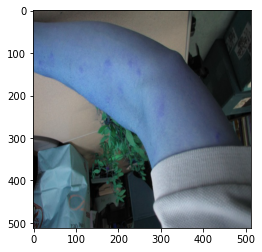

GaussianBlur


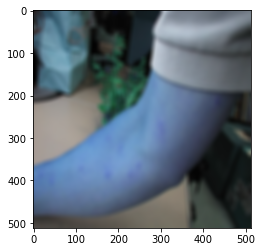

AverageBlur


MotionBlur


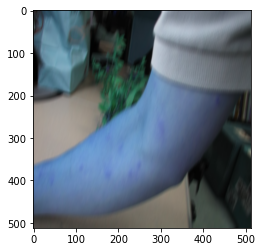

MultiplyBrightness


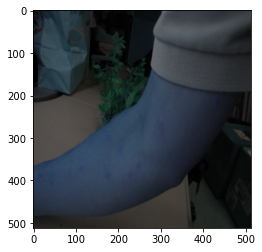

MultiplyHue


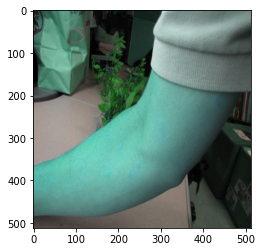

MultiplySaturation


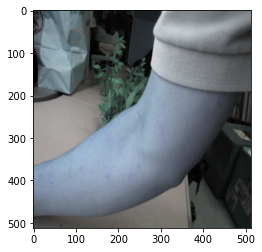

Grayscale


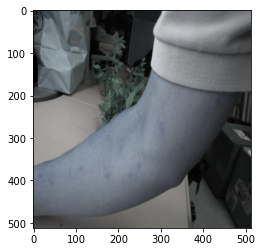

GammaContrast


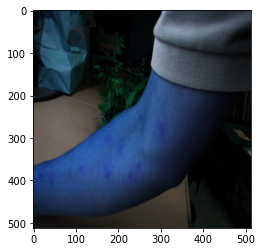

SigmoidContrast


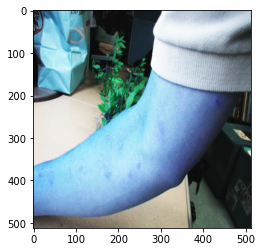

LinearContrast


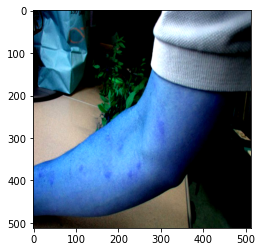

Affine


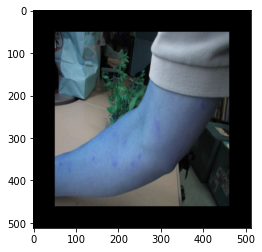

ScaleX


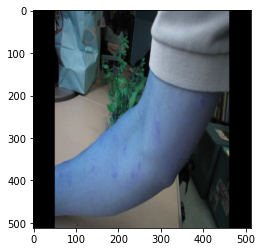

ScaleY


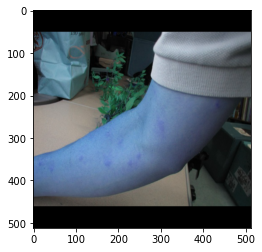

TranslateX


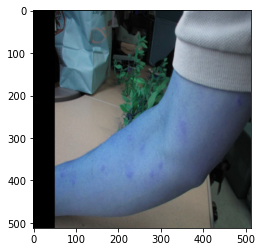

TranslateY


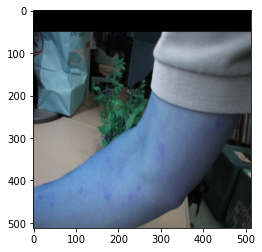

Rotate


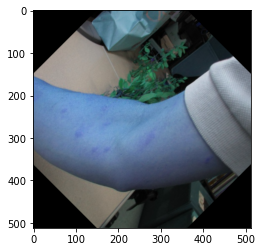

ShearX


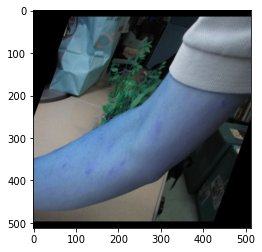

ShearY


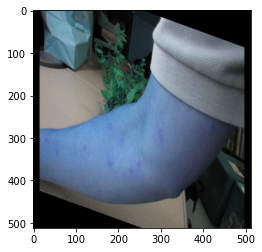

GaussianNoise


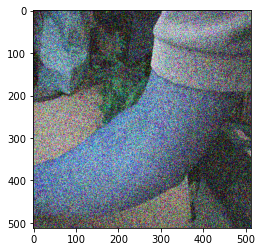

ShotNoise


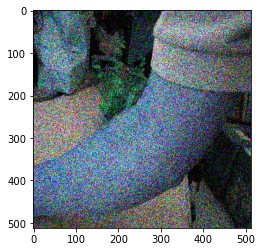

ImpulseNoise


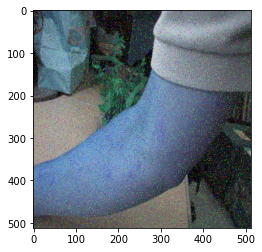

SpeckleNoise


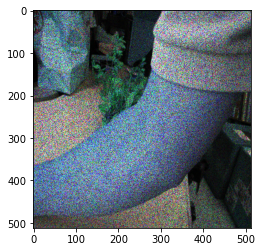

DefocusBlur


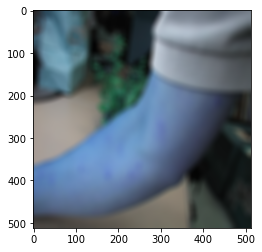

ZoomBlur


Contrast


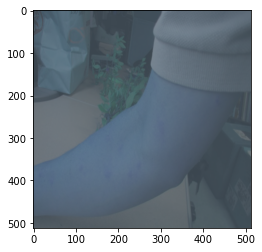

Brightness


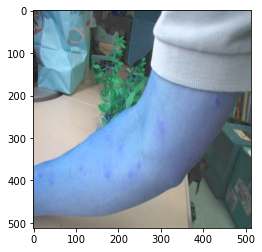

Saturate


Solarize


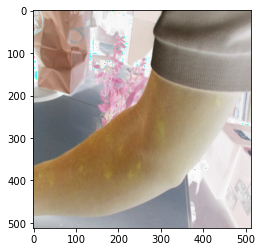

EnhanceColor


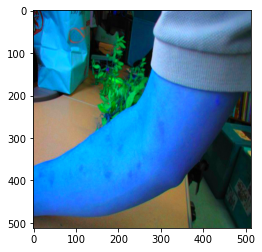

EnhanceContrast


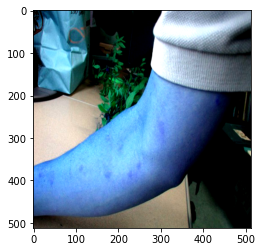

EnhanceBrightness


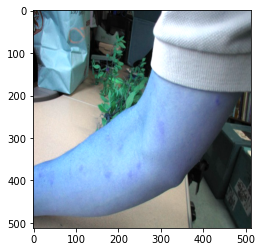

EnhanceSharpness


AdditiveGaussianNoise


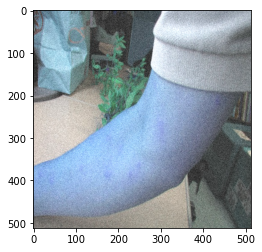

AdditiveLaplaceNoise


AdditivePoissonNoise


Cutout


Dropout


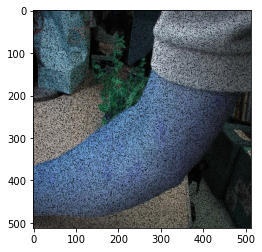

CoarseDropout


SaltAndPepper


In [8]:
# Demonstration on 2 images in augmentation pipeline (full)
for i, img in enumerate(X_train_aug):
    # Show first image and its augmentations
    if i % 2 == 0:
        # Display original image
        if i == 0:
            print("Original")
            plt.imshow(X_train_aug[0])
            plt.show()
        # Display augmented image
        elif i == 2:
            print(list(augs.keys())[i-2])
            plt.imshow(X_train_aug[0])
            plt.show()
        else:
            print(list(augs.keys())[int(i / 2) - 1])
            plt.imshow(X_train_aug[i])
            plt.show()
